In [1]:
from pyiron import Project
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = Project('interstitial')

# Create class

In [ ]:
from scipy.sparse import coo_matrix
from pyiron_atomistics.atomistics.structure.analyse import get_average_of_unique_labels
import numpy as np
from sklearn.cluster import DBSCAN

def get_mean_positions(positions, cell, pbc, labels=None):
    if labels is None:
        labels = np.zeros(len(positions)).astype(int)
    _, labels, counts = np.unique(labels, return_inverse=True, return_counts=True)
    mean_positions = positions[np.unique(labels, return_index=True)[1]]
    all_positions = positions-mean_positions[labels]
    all_positions = np.einsum('ji,nj->ni', np.linalg.inv(cell), all_positions)
    all_positions -= np.rint(all_positions)[:,pbc]
    all_positions = np.einsum('ji,nj->ni', cell, all_positions)
    np.add.at(mean_positions, labels, (all_positions.T/counts[labels]).T)
    return mean_positions

class FindInterstitials:
    def __init__(self, structure, n_gridpoints_per_angstrom=5, min_distance=1):
        self.min_distance = min_distance
        self.structure = structure
        self._create_gridpoints(n_gridpoints_per_angstrom=n_gridpoints_per_angstrom)
        if min_distance > 0:
            self._remove_too_close()

    def _create_gridpoints(self, n_gridpoints_per_angstrom=4):
        cell = self.structure.cell.diagonal()
        gridpoints = (n_gridpoints_per_angstrom*cell).astype(int)
        positions = np.array([np.linspace(0, cell[i], gridpoints[i], endpoint=False) for i in range(3)])
        positions = np.meshgrid(*positions)
        positions = np.stack(positions, axis=-1).reshape(-1, 3)
        self.positions = positions
        
    def _remove_too_close(self):
        neigh = self.structure.get_neighborhood(self.positions, num_neighbors=1)
        self.positions = self.positions[neigh.distances.flatten()>self.min_distance]

    def initialize_neighborhood(self, num_neighbors):
        self.neigh = self.structure.get_neighborhood(self.positions, num_neighbors=num_neighbors)

    def _set_interstitials_to_high_symmetry_points(self, num_neighbors):
        self.positions += np.mean(self.neigh.vecs, axis=-2)
        self.positions = self.structure.get_wrapped_coordinates(self.positions)
        self.initialize_neighborhood(num_neighbors=num_neighbors)

    def _kick_out_points(self, variance_buffer=0.01):
        variance = self.get_variance()
        min_var = variance.min()
        self.positions = self.positions[variance<min_var+variance_buffer]

    def _cluster_points(self, eps=0.1):
        extended_positions, indices = self.structure.get_extended_positions(
            eps, return_indices=True, positions=self.positions
        )
        labels = DBSCAN(eps=eps, min_samples=1).fit_predict(extended_positions)
        x = get_average_of_unique_labels(labels, extended_positions)
        coo = coo_matrix((labels, (np.arange(len(labels)), indices)))
        labels = coo.max(axis=0).toarray().flatten()
        self.positions = get_mean_positions(self.positions, self.structure.cell, self.structure.pbc, labels)

    def get_interstitials(
        self,
        num_neighbors,
        variance_buffer=0.01,
        n_iterations=2,
        eps=0.1,
    ):
        self.initialize_neighborhood(num_neighbors=num_neighbors)
        for _ in range(n_iterations):
            self._set_interstitials_to_high_symmetry_points(num_neighbors=num_neighbors)
        self._kick_out_points(variance_buffer=variance_buffer)
        self._cluster_points(eps=eps)
        self.initialize_neighborhood(num_neighbors=num_neighbors)
        return self.positions
    
    def get_sum_vecs(self):
        return np.linalg.norm(np.sum(self.neigh.vecs, axis=-2), axis=-1)

    def get_variance(self):
        return np.std(self.neigh.distances, axis=-1)

    def get_distance(self, function_to_apply=np.min):
        return function_to_apply(self.neigh.distances, axis=-1)
    
    def get_steinhardt_parameter(self, l):
        return self.neigh.get_steinhardt_parameter(l=l)

In [7]:
def plot(predicted, reference, color=None, marker='o'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    if color is None:
        ax.scatter3D(*predicted.T, marker=marker)
    else:
        ax.scatter3D(*predicted.T, c=color, marker=marker)
    ax.scatter3D(*reference.T, c='red', marker='x', s=100)

![figure](../../0517/INTERSTITIALS/figure.png)

# Perfect crystal

## BCC

In [3]:
bcc = pr.create.structure.bulk('Fe', cubic=True).repeat(2)

In [ ]:
interstitials = bcc.analyse.get_interstitials(num_neighbors=4, initialize_only=True)

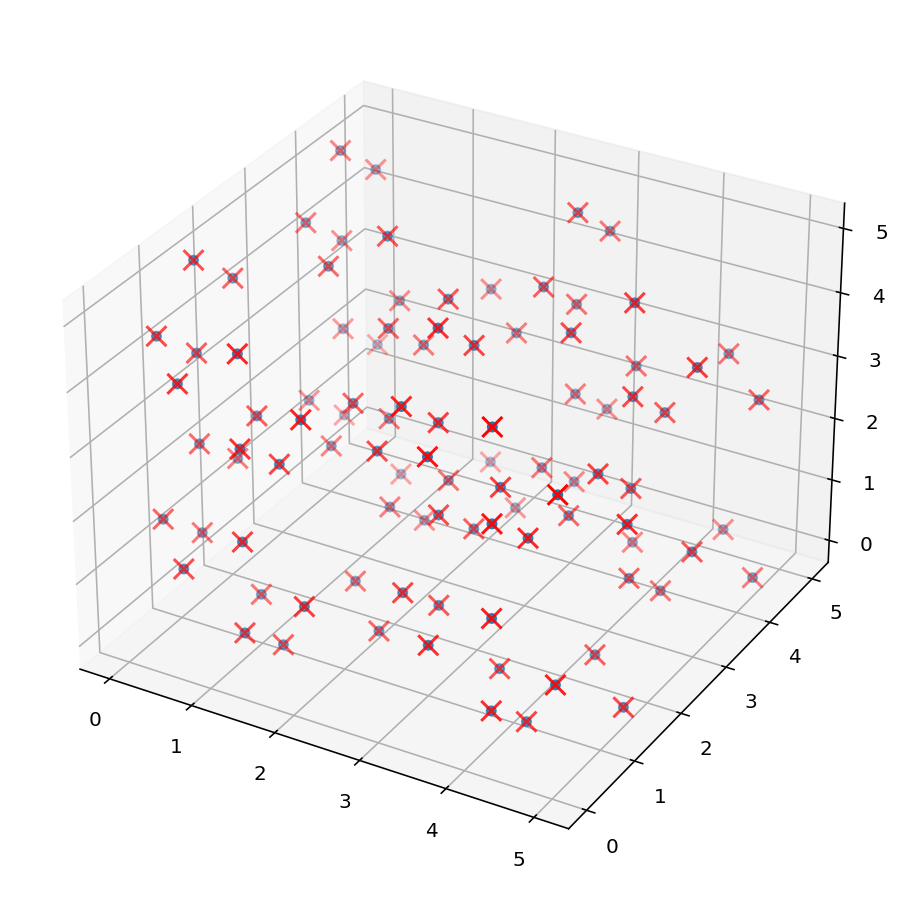

In [8]:
x_tetra = bcc.analyse.get_interstitials(num_neighbors=4)
plot(
    x_tetra,
    bcc.get_wrapped_coordinates(bcc.analyse.get_voronoi_vertices())
)

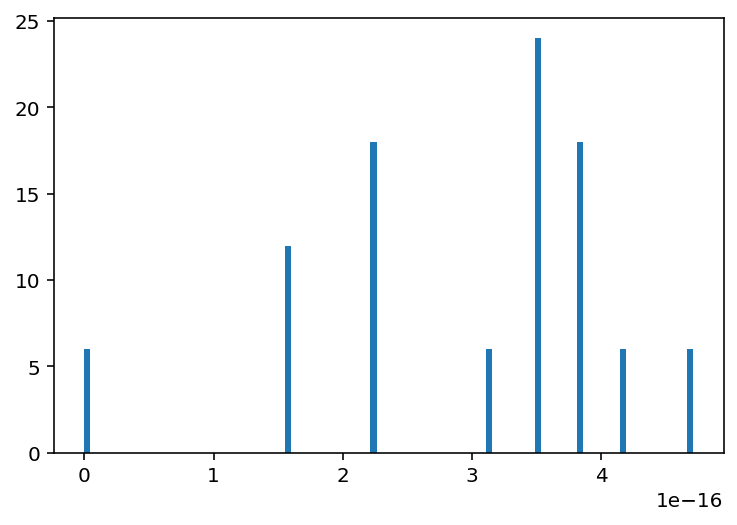

In [48]:
plt.hist(np.std(bcc.analyse.interstitials.neigh.distances, axis=-1), bins=100);

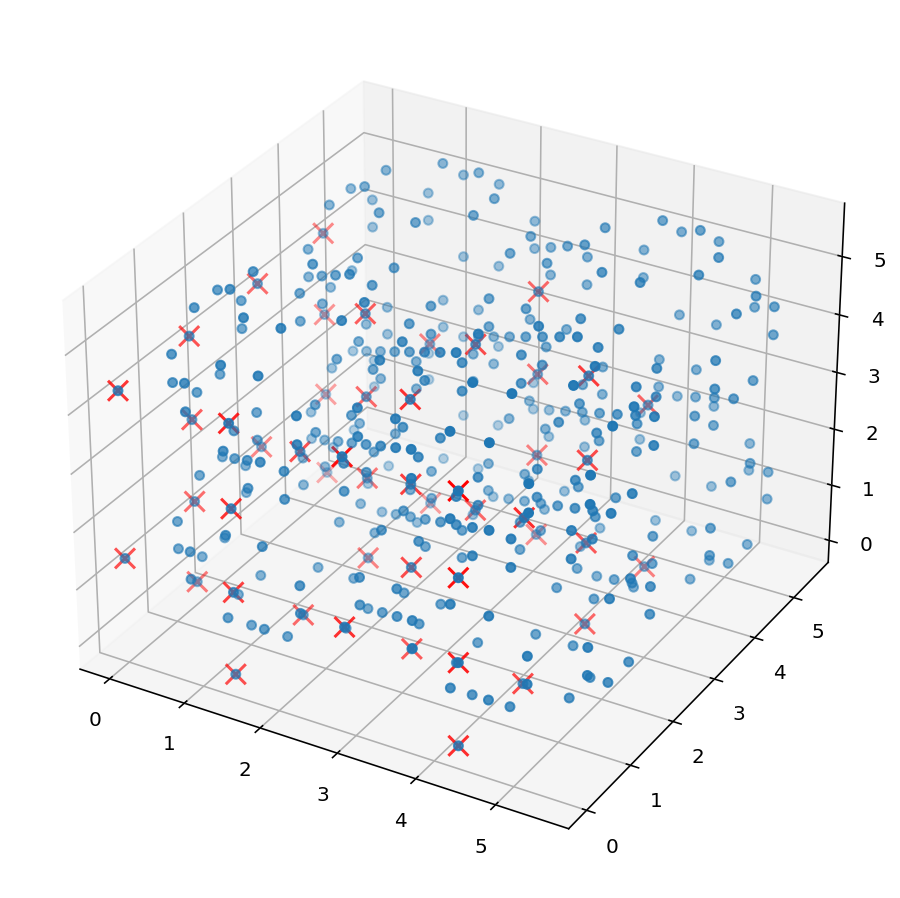

In [51]:
# interstitials = FindInterstitials(bcc, n_gridpoints_per_angstrom=4)

octa_positions = bcc.positions[:,None,:]+0.25*bcc.cell[None,:,:]
octa_positions = octa_positions.reshape(-1, 3)
# interstitials = FindInterstitials(bcc)
x_octa = bcc.analyse.get_interstitials(num_neighbors=6, variance_buffer=np.inf)
plot(
    x_octa,
    bcc.get_wrapped_coordinates(octa_positions),
#     color=interstitials._get_distace()
)

In [ ]:
(bcc+pr.create_atoms(
    positions=np.append(x_tetra, x_octa).reshape(-1, 3),
    elements=len(x_tetra)*['H']+len(x_octa)*['O'],
    cell=bcc.cell
)).plot3d()

## FCC

In [28]:
fcc = pr.create.structure.bulk('Al', cubic=True)
a_0 = fcc.cell[0,0]

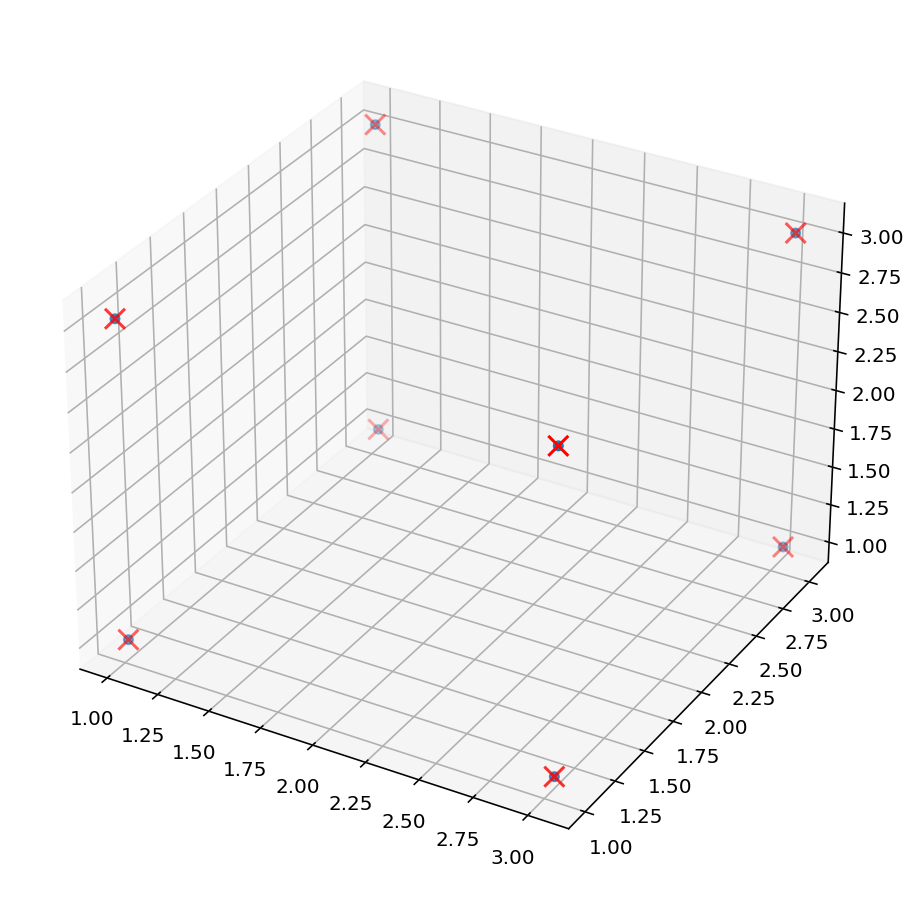

In [29]:
# interstitials = FindInterstitials(fcc)

tetra_positions = 0.25*a_0*np.ones(3)*np.array([[1],[-1]])+fcc.positions[:,None,:]
tetra_positions = fcc.get_wrapped_coordinates(tetra_positions).reshape(-1, 3)

plot(
    fcc.analyse.get_interstitials(num_neighbors=4),
    tetra_positions
)

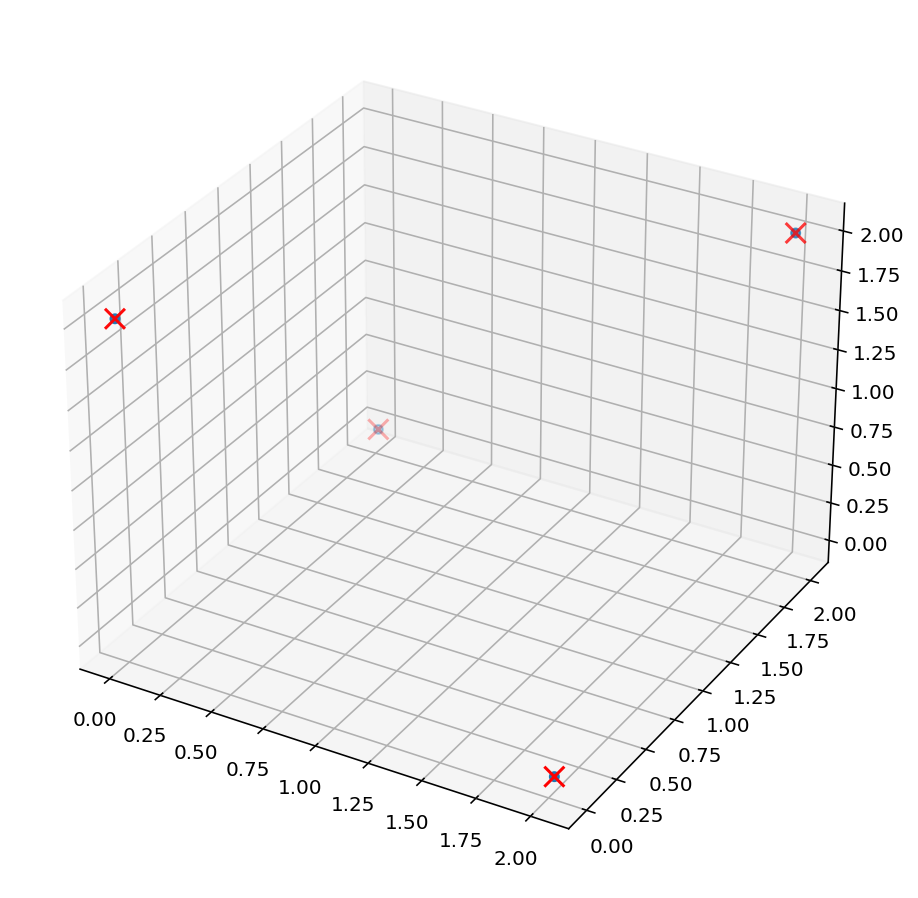

In [33]:
# interstitials = FindInterstitials(fcc)

octa_positions = 0.5*a_0*np.array([1, 0, 0])+fcc.positions
octa_positions = fcc.get_wrapped_coordinates(octa_positions)

plot(
    fcc.analyse.get_interstitials(num_neighbors=6),
    octa_positions
)

In [46]:
cell = [[1, 1, 0], [0, 1, 0], [0, 0, 1]]
np.linalg.det(cell)/np.linalg.norm(
    np.cross(np.roll(cell, -1, axis=0), np.roll(cell, 1, axis=0)),
    axis=-1,
)    


array([1.        , 0.70710678, 1.        ])

In [45]:
a_0**2*np.sqrt(3)

28.409963371148507

In [37]:
fcc.analyse.interstitials.get_area()

array([28.40996337, 28.40996337, 28.40996337, 28.40996337])

In [36]:
fcc.analyse.interstitials.get_volume()

array([11.0716875, 11.0716875, 11.0716875, 11.0716875])

In [40]:
fcc.get_volume(per_atom=True)

16.607531250000005

# Grain boundary

In [ ]:
axis = [0, 0, 1]
max_sigma = 5
gb_dict = pr.create.structure.aimsgb.info(axis, max_sigma)
sigma = list(gb_dict.keys())[-1]
plane = gb_dict[sigma]['plane'][0][0]

In [ ]:
layer = '0b1t0b1t'
gb_bcc = pr.create.structure.aimsgb.build(axis, sigma, plane, bcc, delete_layer=layer)

In [ ]:
lmp = pr.create.job.Lammps(f'gb_bcc_{sigma}_{layer}')
lmp.structure = gb_bcc
lmp.potential = lmp.list_potentials()[0]
lmp.calc_minimize(pressure=0, ionic_force_tolerance=1.0e-6)
lmp.run()

In [ ]:
gb_bcc_relaxed = lmp.get_structure()

In [ ]:
gb_bcc_relaxed.plot3d()

In [ ]:
v_Fe = np.zeros(len(gb_bcc_relaxed))
# interstitials = FindInterstitials(gb_bcc_relaxed)
# x = interstitials.get_interstitials(num_neighbors=4, variance_buffer=1)

In [ ]:
fig = plt.figure(figsize=gb_bcc_relaxed.cell.diagonal()[:2]/2)
plt.scatter(*gb_bcc_relaxed.positions.T[:2])
x = gb_bcc_relaxed.analyse.get_interstitials(num_neighbors=4, variance_buffer=0.2)
plt.scatter(*x.T[:2], marker='x')

In [ ]:
(gb_bcc_relaxed+pr.create_atoms(positions=x, elements=len(x)*['H'], cell=gb_bcc_relaxed.cell)).plot3d()

In [ ]:
v_Fe = np.zeros(len(gb_bcc_relaxed))
interstitials = FindInterstitials(gb_bcc_relaxed)
x = interstitials.get_interstitials(
    num_neighbors=6, variance_buffer=0.2, n_iterations=2, eps=0.7
)

In [ ]:
plt.hist(gb_bcc_relaxed.analyse.interstitials.get_distance(), bins=100);

In [ ]:
m = np.mean((interstitials.neigh.distances-np.mean(interstitials.neigh.distances, axis=-1)[:,None])**4, axis=-1)
m = interstitials.get_steinhardt_parameter(4)
fig = plt.figure(figsize=gb_bcc_relaxed.cell.diagonal()[:2]/2)
plt.scatter(*gb_bcc_relaxed.positions.T[:2], marker='x', s=100, color='red')
# plt.scatter(*x.T[:2], marker='o', c=interstitials._get_variance())
plt.scatter(*x.T[:2], marker='o', c=m)
plt.colorbar()

In [ ]:
(gb_bcc_relaxed+pr.create_atoms(positions=x, elements=len(x)*['H'], cell=gb_bcc_relaxed.cell)).plot3d()

In [ ]:
plt.hist(interstitials.get_steinhardt_parameter(4), bins=100);

In [ ]:
plt.hist(m, bins=100);

In [ ]:
bcc.analyse.interstitials = interstitials

In [ ]:
bcc.analyse.get_interstitials()

structure.analyse.find_interstitials() -> structure.analyse.interstitials.find_interstitials()?